In [868]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## test
import keras as k

In [869]:
plate_cascade = cv2.CascadeClassifier("./model/haarcascade_russian_plate_number.xml")

In [870]:
model = k.models.load_model('model/model_use_ai_based_indian_plate_detection.keras')

In [871]:
def resize_image(image, width = None, height = None):

    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

In [872]:
# Визначає та виконує розмиття на номерних знаках
def extract_plate(img, plate_cascade, text=""):
    # Завантажує дані, необхідні для виявлення номерних знаків, з каскадного класифікатора.
    # plate_cascade = cv2.CascadeClassifier(full_path_cascad)
    # plate_cascade = cv2.CascadeClassifier('D:\Python\github\PlateN\DS\models\haarcascade_russian_plate_number.xml')

    # plate_img = img.copy()
    # roi = img.copy()
    plate_img = cv2.convertScaleAbs(resize_image(img, width=460)) #.copy()
    roi = plate_img.copy()
    plate = None
    # Виявляє номерні знаки та повертає координати та розміри контурів виявлених номерних знаків.
    plate_rect = plate_cascade.detectMultiScale(
        plate_img, scaleFactor=1.05, minNeighbors=8
    )

    width_max = 0  # використовується для сортування за шириною
    plate_max = None
    x_max = 0
    y_max = 0

    for x, y, w, h in plate_rect:
        # виконує пропорційне зміщення пікселів
        a, b = (int(0.1 * h), int(0.1 * w))
        aa, bb = (int(0.1 * h), int(0.1 * w))

        if h > 75:  # пропускає розбиття за шириною високоякісного зображення
            b = 0
            bb = 0

        plate = roi[y + a : y + h - aa, x + b : x + w - bb, :]

        if width_max < w:
            plate_max = plate
            width_max = w
            x_max = x
            y_max = y

        # представлення виявлених контурів за допомогою малювання прямокутників навколо країв:
        cv2.rectangle(plate_img, (x + 2, y), (x + w - 3, y + h - 5), (51, 224, 172), 3)
    
    if text != "":
        h = plate_max.shape[0]
        plate_img = cv2.putText(
            plate_img,
            text,
            (x_max, y_max - h // 3),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            1.5,
            (51, 224, 172),
            2,
            cv2.LINE_AA,
        )

    return plate_img, plate_max

In [873]:
# Відповідність контурів номерному або символьному шаблону
def find_contours(dimensions, img, debug=False):
    i_width_threshold = 6

    # Знайдіть всі контури на зображенні
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Отримайте потенційні розміри
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Перевірте найбільші 16 контурів на номерний або символьний шаблон
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:16]

    # бінарне зображення номерного знака на вхід: щоб перетворити img.shape(h,w) на img.shape(h,w,3)
    ii = np.dstack([img] * 3)

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # виявлення контуру на бінарному зображенні і повернення координат прямокутника, який його оточує
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # перевірка розмірів контуру для фільтрації символів за розміром контуру
        if (
            intWidth >= i_width_threshold
            and intWidth < upper_width
            and intHeight > lower_height
            and intHeight < upper_height
        ):
            x_cntr_list.append(
                intX
            )  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44, 24))
            # видобуття кожного символу, використовуючи координати прямокутника, що його оточує.
            char = img[intY : intY + intHeight, intX : intX + intWidth]

            if intWidth >= i_width_threshold and intWidth < lower_width:
                i_char = cv2.resize(
                    char, (intWidth, 42), interpolation=cv2.INTER_LINEAR_EXACT
                )

                char = np.full((42, 22), 255, dtype=np.uint8)
                begin = int((22 - intWidth) / 2)  # center alignment
                char[:, begin : begin + intWidth] = i_char[:, :]
            else:
                char = cv2.resize(char, (22, 42), interpolation=cv2.INTER_LINEAR_EXACT)

            cv2.rectangle(
                ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2
            )
            if debug :
              plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[1:43, 1:23] = char
            char_copy[0:1, :] = 0
            char_copy[:, 0:1] = 0
            char_copy[43:44, :] = 0
            char_copy[:, 23:24] = 0

            img_res.append(
                char_copy
            )  # List that stores the character's binary image (unsorted)
            if len(img_res) >= 10:
                break

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    if debug:
        plt.axis('off')
        plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(
            img_res[idx]
        )  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [874]:
# Find characters in the resulting images
def segment_characters(image, debug: bool = False):
    new_height = 75  # set fixed height

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, new_height), interpolation=cv2.INTER_LINEAR_EXACT)

    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 112, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[new_height - 3 : new_height, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 24, LP_WIDTH / 8, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
    # dimensions = [LP_WIDTH/6, LP_WIDTH / 2, LP_HEIGHT / 3, 2 * LP_HEIGHT / 3]
    # dimensions = [LP_WIDTH/12, LP_WIDTH / 4, LP_HEIGHT / 2, 2 * LP_HEIGHT / 3]

    plt.imshow(img_binary_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    # if debug:
    #     plt.imshow(img_binary_lp, cmap='gray')
    #     plt.title("original plate contour (binary)")
    #     plt.show()

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp, debug = debug)

    for i in range(len(char_list)):
        plt.subplot(1, 10, i+1)
        plt.imshow(char_list[i], cmap='gray')
        plt.axis('off')

    return char_list

In [875]:
#Rotate the plate (if tilted)



In [876]:
# Predicting the output
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


def show_results(characters_plate, debug=False):
    dic = {}
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i, c in enumerate(characters):
        dic[i] = c

    plt.figure(figsize=(15, 6))
    output = []
    for i, ch in enumerate(characters_plate):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_ = np.argmax(model.predict(img, verbose=False), axis=-1)[0]  # predicting the class
        character = dic[y_]  #
        output.append(character)  # storing the result in a list
        if debug:
            plt.subplot(3, 9, i + 1)
            plt.imshow(img_, cmap="gray")
            plt.title(f"prediction : {character}")
            plt.axis("off")

    if debug:
        plt.show()

    plate_number = "".join(output)

    return plate_number

In [877]:
def show_image(image, title=""):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

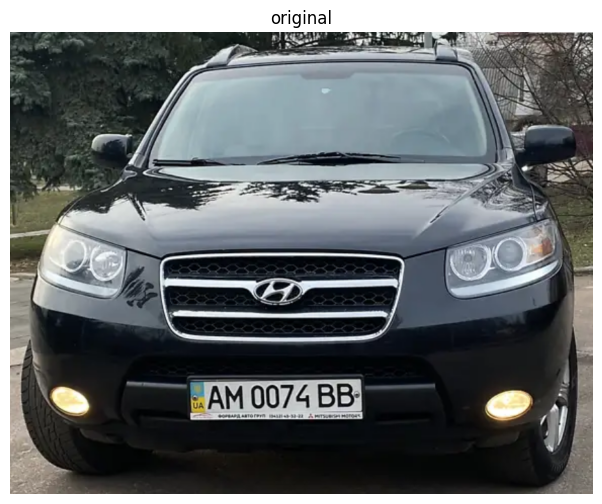

In [878]:
img_car_original = cv2.imread('image_vehile/AM0074BB.png')

show_image(img_car_original, "original")

In [879]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

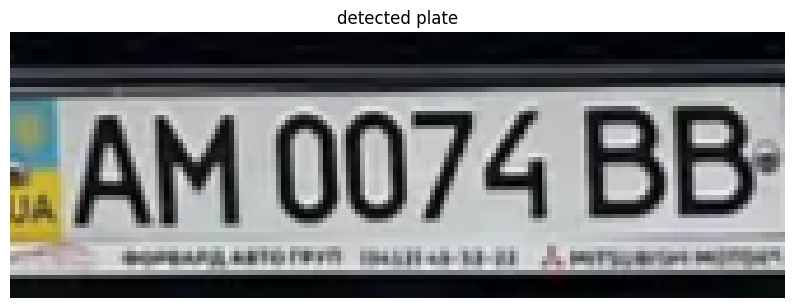

In [880]:
show_image(plate, "detected plate")

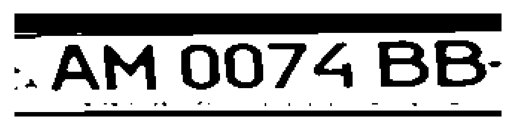

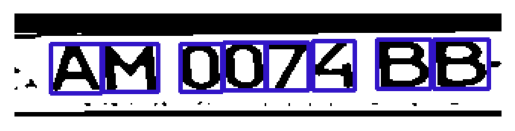

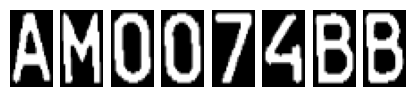

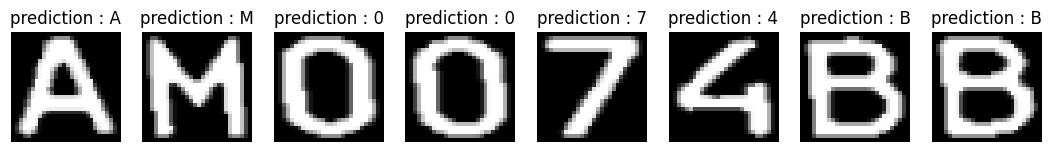

AM0074BB


In [881]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

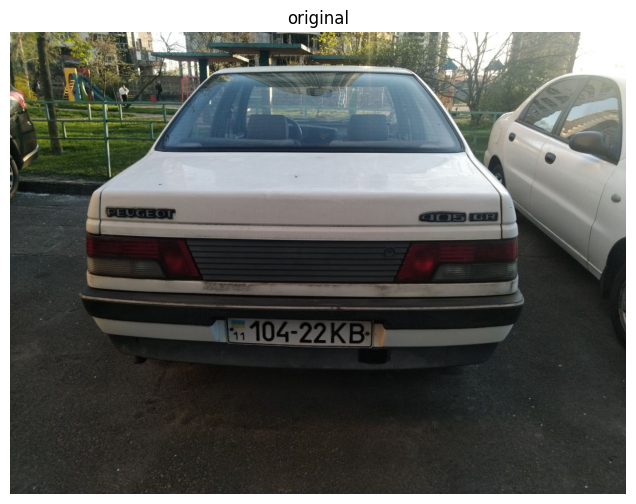

In [882]:
img_car_original = cv2.imread('image_vehile/10422KB.jpg')

show_image(img_car_original, "original")

In [883]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

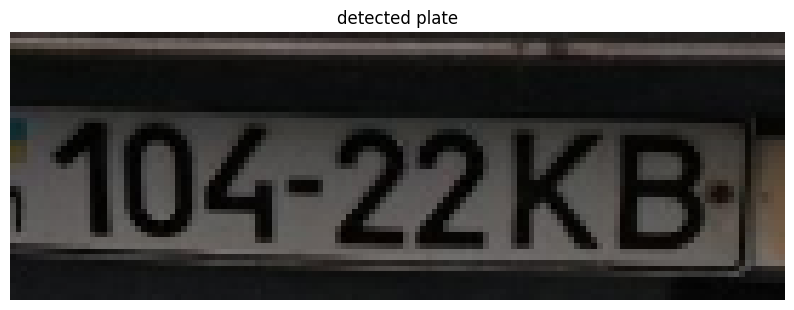

In [884]:
show_image(plate, "detected plate")

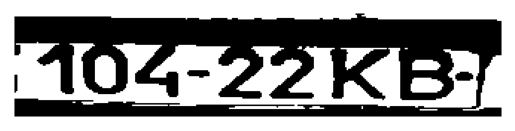

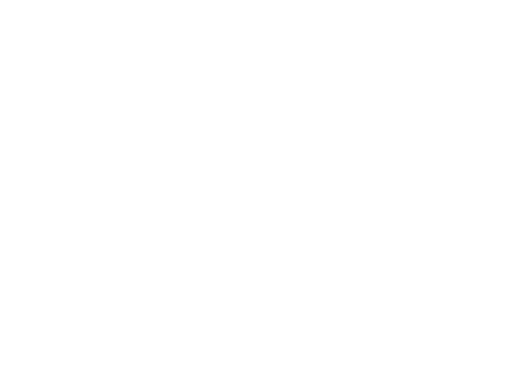

<Figure size 1500x600 with 0 Axes>

In [885]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

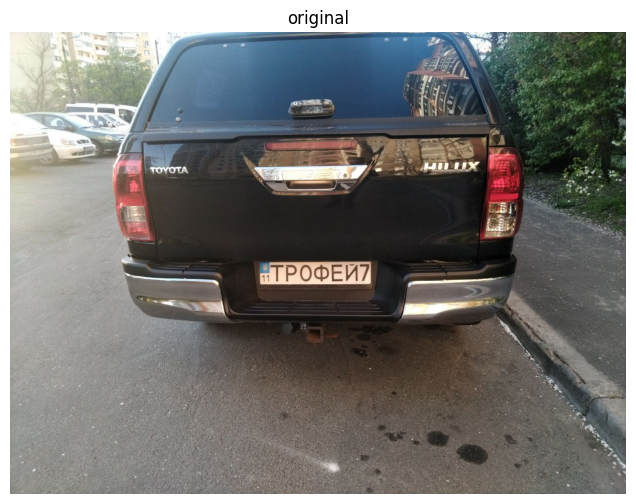

In [886]:
img_car_original = cv2.imread('image_vehile/trofei7.jpg')

show_image(img_car_original, "original")

In [887]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

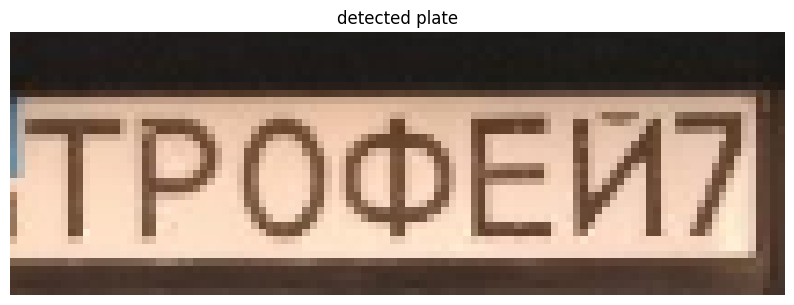

In [888]:
show_image(plate, "detected plate")

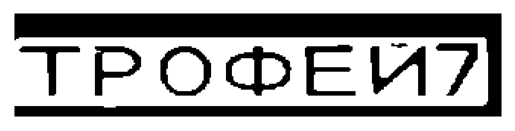

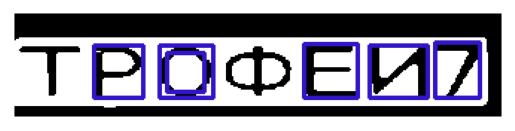

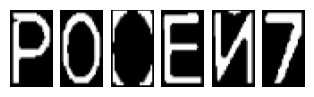

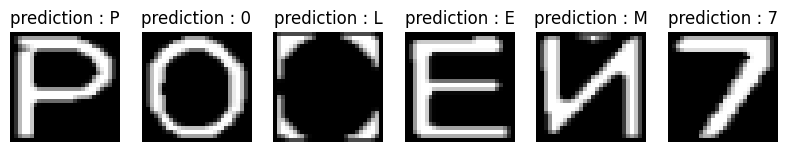

P0LEM7


In [889]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

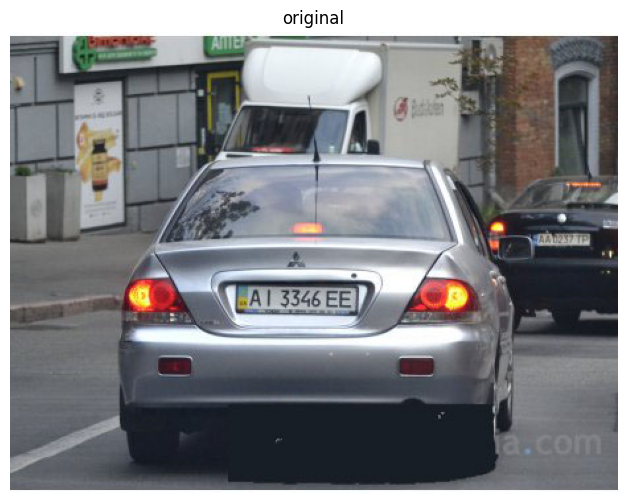

In [890]:
img_car_original = cv2.imread('image_vehile/AI 3346 EE.jpg')

show_image(img_car_original, "original")

In [891]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

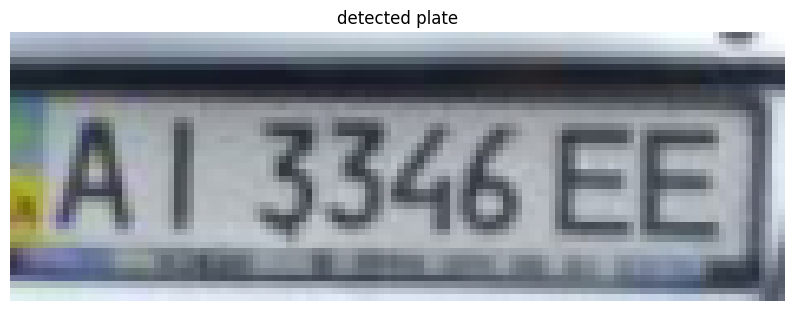

In [892]:
show_image(plate, "detected plate")

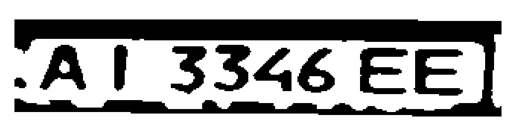

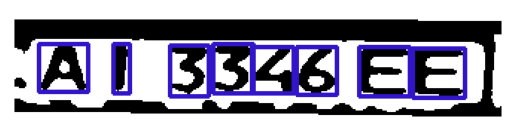

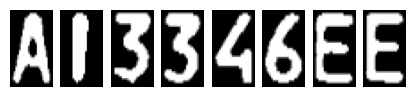

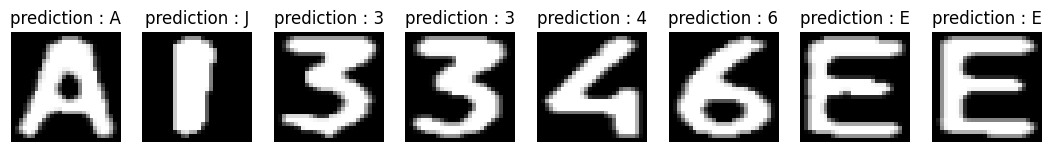

AJ3346EE


In [893]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

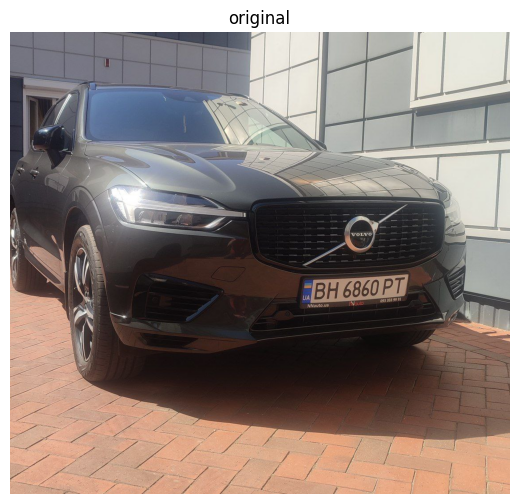

In [894]:
img_car_original = cv2.imread('image_vehile/real_image/BH 6860 PT.jpg')

show_image(img_car_original, "original")

In [895]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

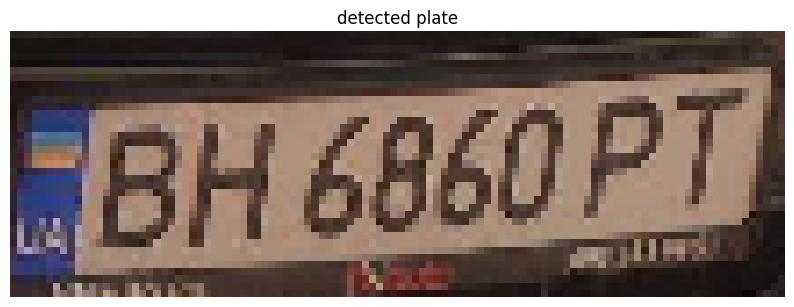

In [896]:
show_image(plate, "detected plate")

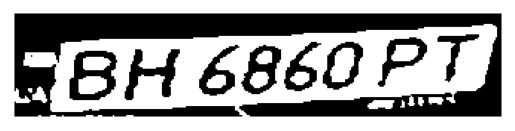

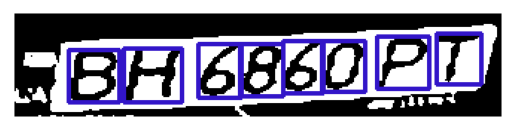

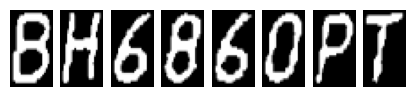

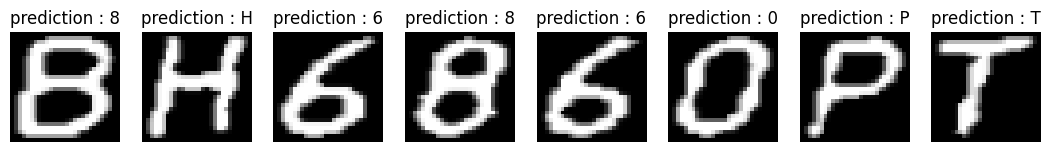

8H6860PT


In [897]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

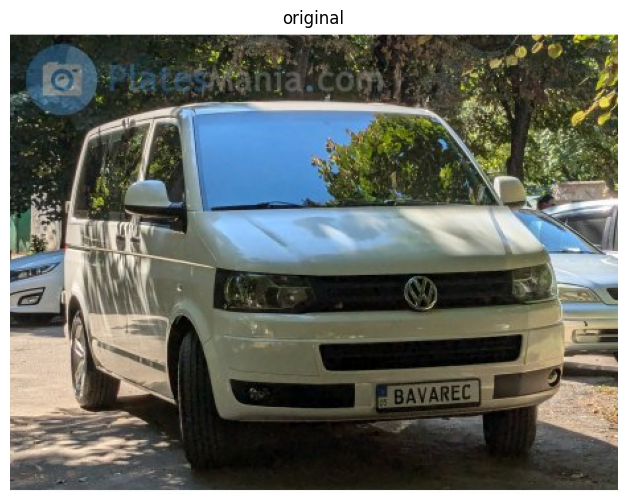

In [898]:
img_car_original = cv2.imread('image_vehile/05 BAVAREC.jpg')

show_image(img_car_original, "original")

In [899]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

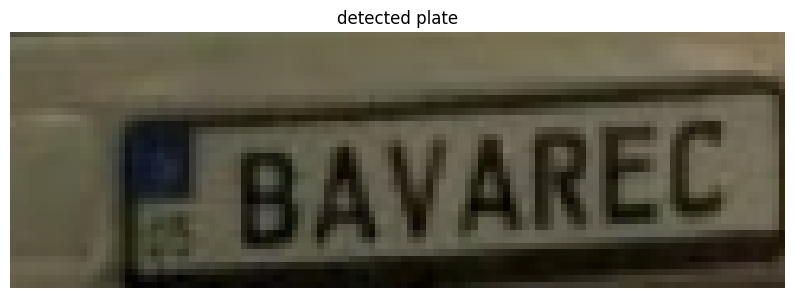

In [900]:
show_image(plate, "detected plate")

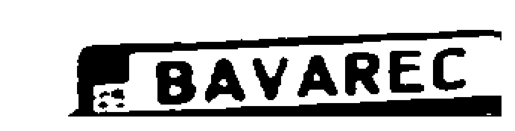

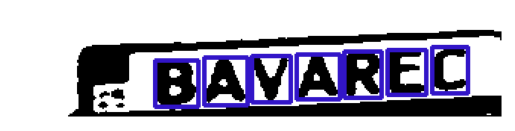

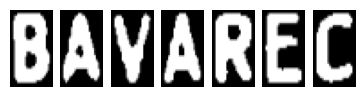

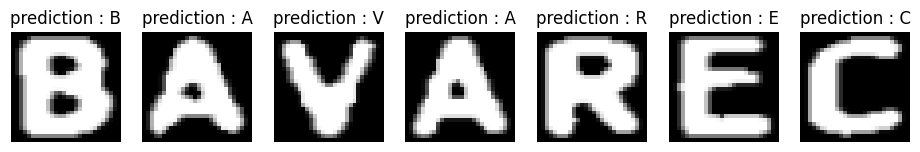

BAVAREC


In [901]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

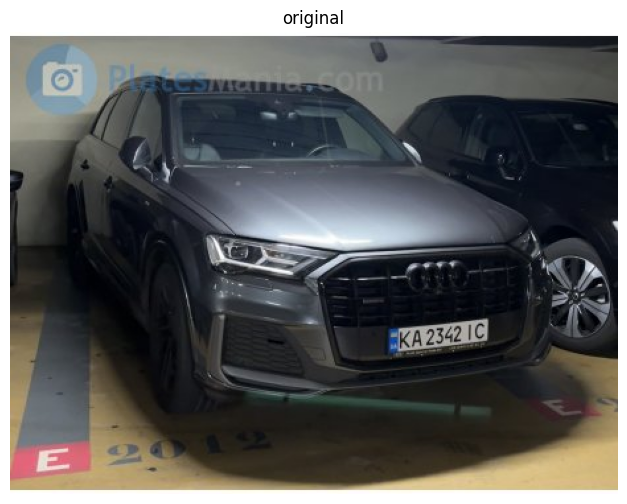

In [902]:
img_car_original = cv2.imread('image_vehile/KA 2342 IC.jpg')

show_image(img_car_original, "original")

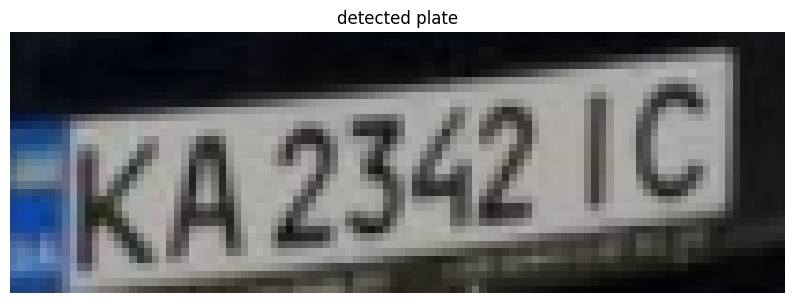

In [903]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

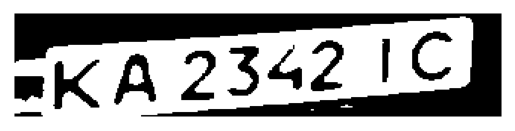

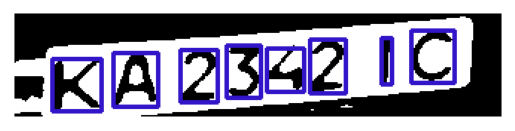

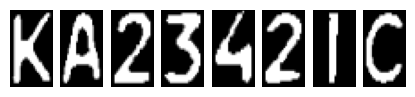

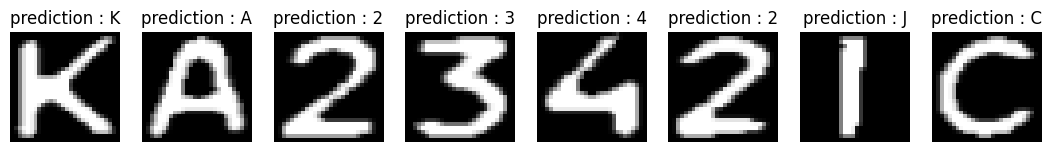

KA2342JC


In [904]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

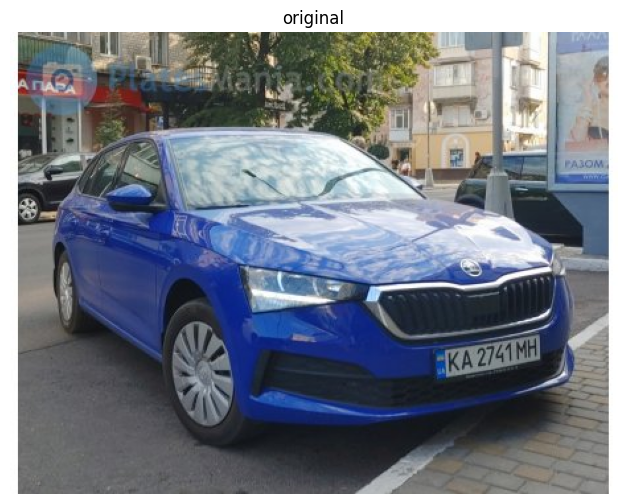

In [905]:
img_car_original = cv2.imread('image_vehile/KA 2741 MH.jpg')

show_image(img_car_original, "original")

In [906]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


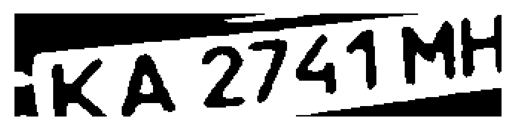

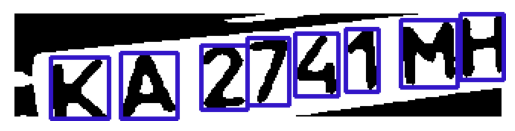

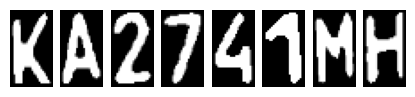

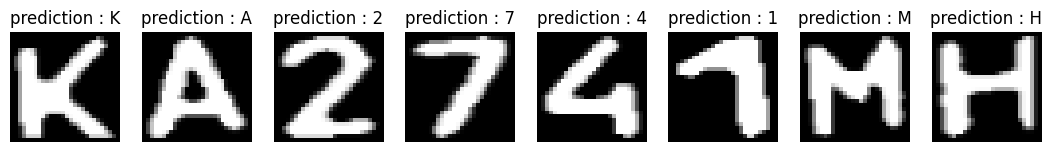

KA2741MH


In [851]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

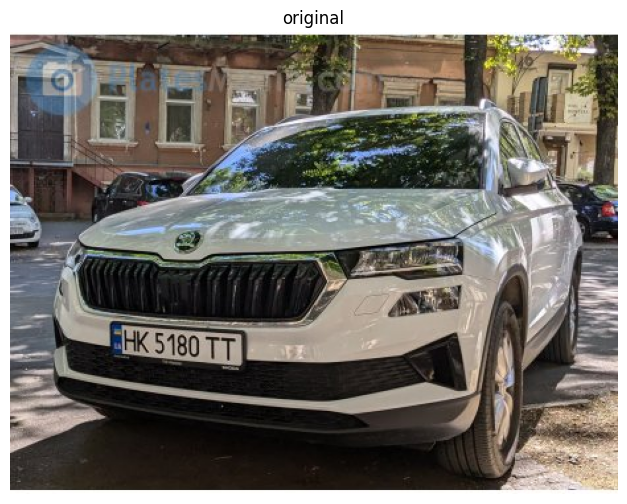

In [852]:
img_car_original = cv2.imread('image_vehile/HK 5180 TT.jpg')

show_image(img_car_original, "original")

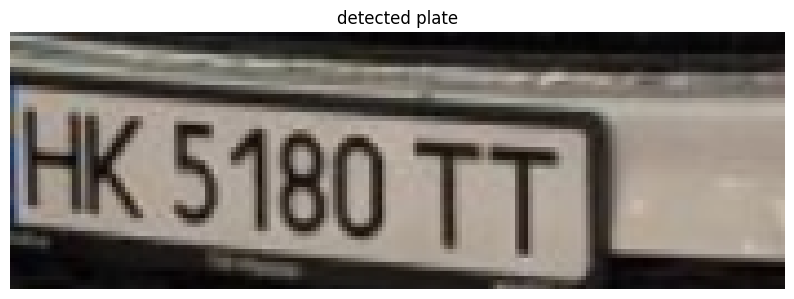

In [853]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

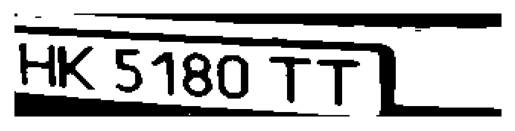

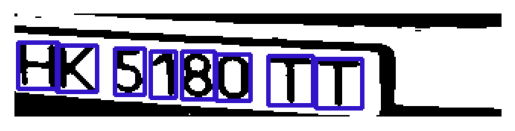

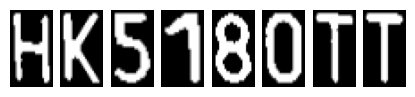

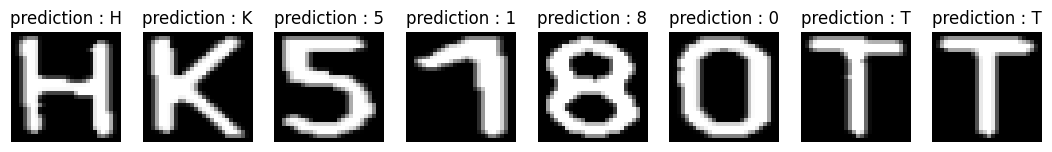

HK5180TT


In [854]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

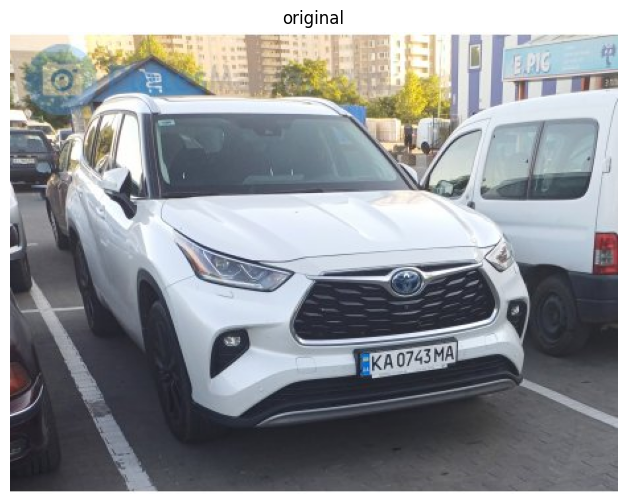

In [855]:
img_car_original = cv2.imread('image_vehile/KA 0743 MA.jpg')

show_image(img_car_original, "original")

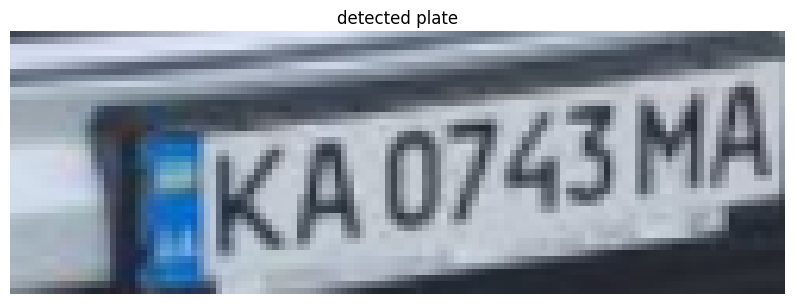

In [856]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

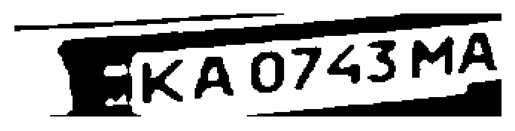

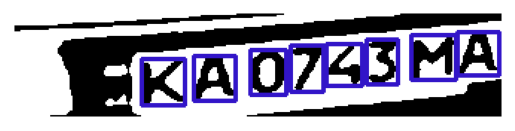

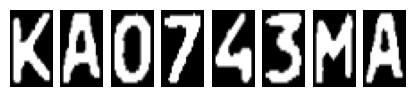

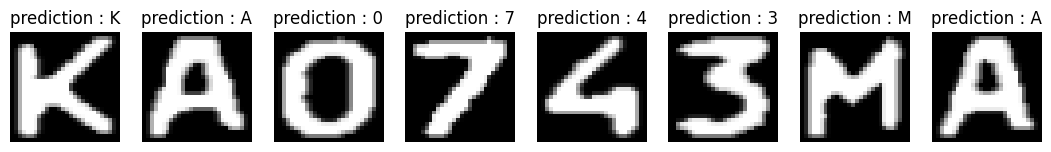

KA0743MA


In [857]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

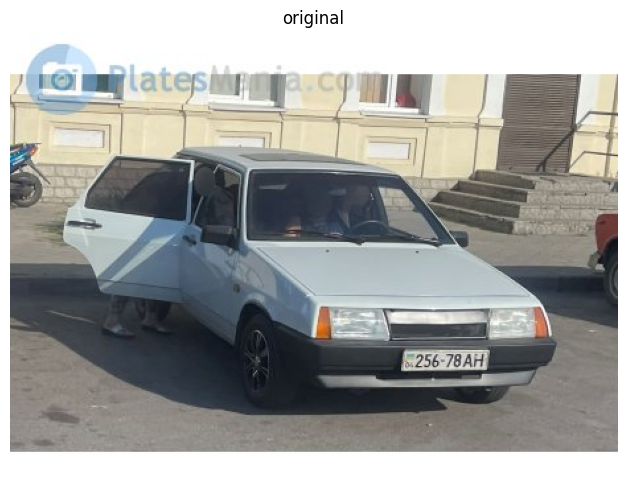

In [858]:
img_car_original = cv2.imread('image_vehile/04 256-78 AH.jpg')

show_image(img_car_original, "original")

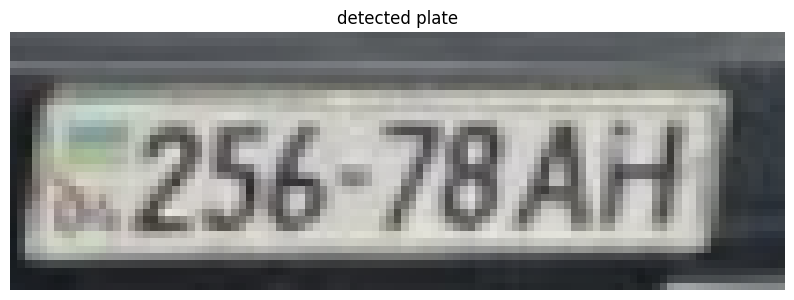

In [859]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

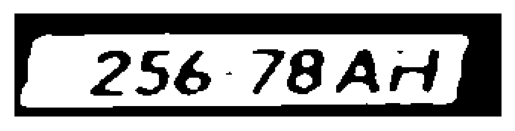

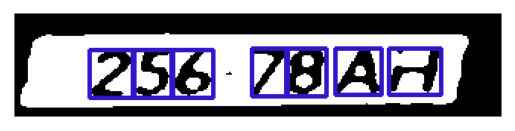

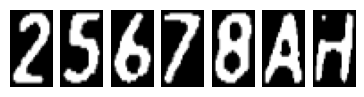

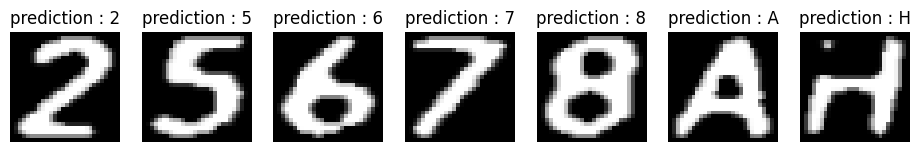

25678AH


In [860]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

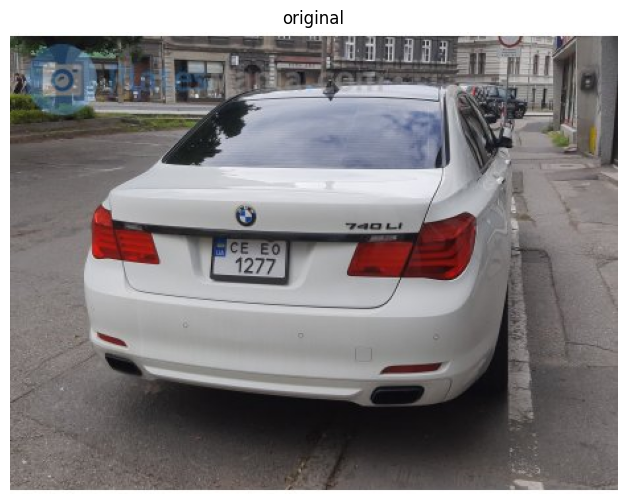

In [861]:
img_car_original = cv2.imread('image_vehile/CE 1277 EO.jpg')

show_image(img_car_original, "original")

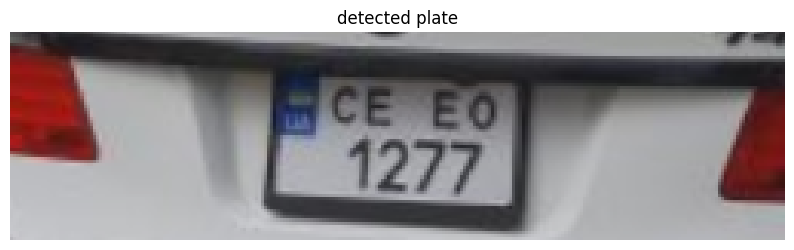

In [862]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

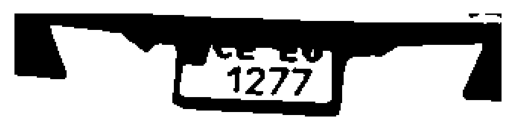

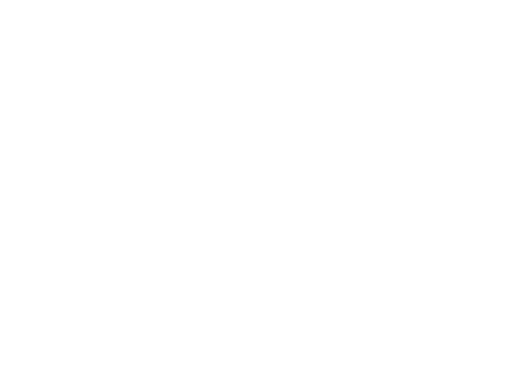

<Figure size 1500x600 with 0 Axes>

In [863]:
characters_plate =segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))

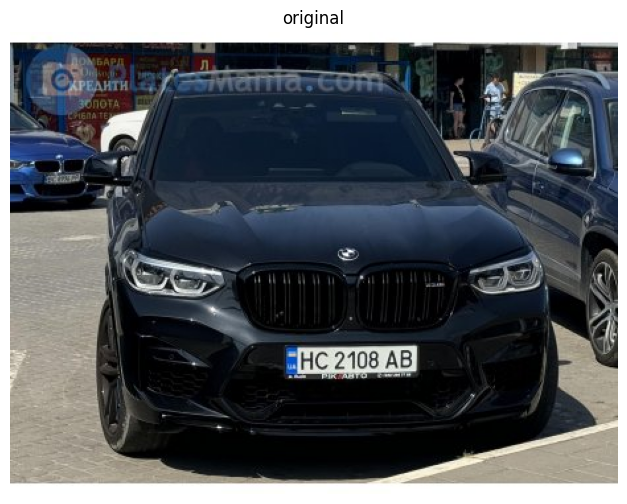

In [864]:
img_car_original = cv2.imread('image_vehile/HC 2108 AB.jpg')

show_image(img_car_original, "original")

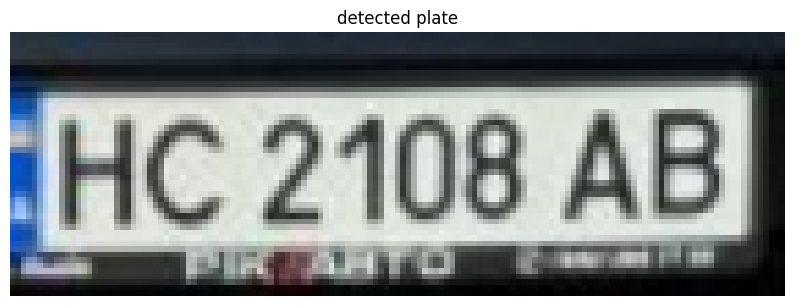

In [865]:
output_img, plate = extract_plate(img_car_original, plate_cascade)

show_image(plate, "detected plate")

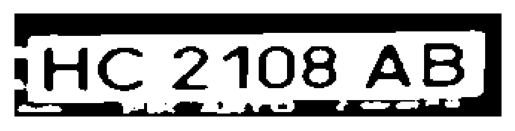

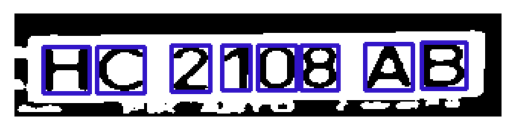

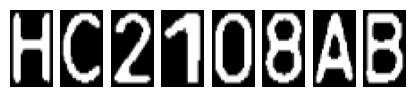

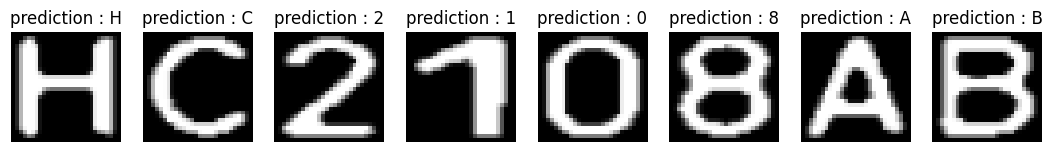

HC2108AB


In [866]:
characters_plate = segment_characters(plate, debug=True)

print(show_results(characters_plate, debug=True))